# Text Summarization

You task is to prepare a model that is suitable for text summarization.
We gonna use `CNN_dailymail` dataset

In [ ]:
!pip -q install datasets transformers evaluate rouge_score
from datasets import load_dataset
from evaluate import load

import math
import numpy as np
import torch
import os
from torch import nn
from torch.utils.data import Dataset, DataLoader

dataset = load_dataset("abisee/cnn_dailymail", '3.0.0')
metric = load("rouge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Now you have to prepare your dataset
Use any tokenization methods you'd like <br>
If you are using guides please cite your source

In [ ]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
# from transformers import PreTrainedTokenizerFast

### Pretrained tokenizer for T5

In [ ]:
from transformers import T5Tokenizer
from transformers import AutoTokenizer

In [ ]:
max_input_length = 512
max_target_length = 256

def preprocess_function(examples):
    inputs = [doc for doc in examples["article"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, padding='max_length')

    # Setup the tokenizer for targets
    labels = tokenizer(text_target=examples["highlights"], max_length=max_target_length, truncation=True, padding='max_length')

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


tokenizer = AutoTokenizer.from_pretrained('t5-small')  # use tokenizer suitable for seq2seq task, like yours
tokenizer.add_special_tokens({"bos_token": "<start>"})

1

In [ ]:
tokenized_dataset = dataset.map(preprocess_function, batched=True, num_proc=4)  # use 4 or 8 on Collab. Note, that this gonna take some time. For example purpose you might want to process few entries
tokenized_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
display(tokenized_dataset)

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 11490
    })
})

In [ ]:
tokenized_dataset["train"]["input_ids"].shape

torch.Size([287113, 512])

In [ ]:
tokenized_dataset["train"]["labels"][0].shape

torch.Size([256])

## Declare  your model (6 pts)
Use encoder-decoder transformer architecure of any size <br>
You can lookup for a T5 architecure





In [ ]:
import torch.nn.functional as F

class Head(nn.Module):
    """
    One head for a non masked multihead attention mechanism implementation.
    """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(embedding_size, head_size, bias=False)
        self.query = nn.Linear(embedding_size, head_size, bias=False)
        self.value = nn.Linear(embedding_size, head_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        samples_number, sequence_length, embedding_size  = x.shape
        K, Q, V = self.key(x), self.query(x), self.value(x)
        w = Q @ K.transpose(-2, -1) / np.sqrt(K.shape[-1])
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        return w @ V

class MaskedHead(nn.Module):
    """
    One head for a masked multihead attention mechanism implementation.
    Fucking stupid dimensions. I don't want anymore to think how to pass this.
    """
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(embedding_size, head_size, bias=False)
        self.query = nn.Linear(embedding_size, head_size, bias=False)
        self.value = nn.Linear(embedding_size, head_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        samples_number, sequence_length, embedding_size = x.shape
        K, Q, V = self.key(x), self.query(x), self.value(x)
        w = Q @ K.transpose(-2, -1) / np.sqrt(K.shape[-1])
        tril = torch.tril(torch.ones(sequence_length, sequence_length)).to(device)
        w = w.masked_fill(tril == 0, float("-inf"))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        return w @ V


class MultiHeadAttention(nn.Module):
    """
    Multihead attention mechanism implementation.
    """
    def __init__(self, num_heads, head_size, masked):
        super().__init__()
        self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)]) if masked else nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(head_size * num_heads, embedding_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        return self.dropout(self.projection(out))


class CrossAttentionHead(Head):
    """
    Another head, but now for cross attention.
    It needs to accept separate Q, K, V inputs and doesn't need mask.
    It is inherited from basic Head class.
    """
    def forward(self, q, kv):
        samples_number, q_sequence_length, _ = q.shape
        _, kv_sequence_length, _ = kv.shape
        Q = self.query(q)
        K = self.key(kv)
        V = self.value(kv)
        w = Q @ K.transpose(-2, -1) / np.sqrt(K.shape[-1])
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        return w @ V


class CrossMultiHeadAttention(nn.Module):
    """
    Cross attention mechanism implementation.
    """
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([CrossAttentionHead(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(head_size * num_heads, embedding_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, kv):
        out = torch.cat([head(q, kv) for head in self.heads], dim=-1)
        out = self.projection(out)
        return self.dropout(out)


class FeedForward(nn.Module):
    """
    Feed Forward layers for encoder and decoder.
    """
    def __init__(self, embedding_size):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(embedding_size, 4*embedding_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(4*embedding_size, embedding_size),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)


class EncoderBlock(nn.Module):
    """
    Transformer Encoder Block.
    """
    def __init__(self, embedding_size, n_head):
        super().__init__()
        head_size = embedding_size // n_head
        self.attn = MultiHeadAttention(n_head, head_size, masked=False)
        self.feed_forward = FeedForward(embedding_size)
        self.layer_norm1 = nn.LayerNorm(embedding_size)
        self.layer_norm2 = nn.LayerNorm(embedding_size)

    def forward(self, x):
        x = x.float()
        x = x + self.attn(self.layer_norm1(x))
        x = x + self.feed_forward(self.layer_norm2(x))
        return x


class DecoderBlock(nn.Module):
    """
    Transformer Decoder Block.
    """
    def __init__(self, block_size, n_head):
        super().__init__()
        head_size = block_size // n_head
        self.masked_attn = MultiHeadAttention(n_head, head_size, masked=True)
        self.layer_norm1 = nn.LayerNorm(embedding_size)
        self.layer_norm2 = nn.LayerNorm(embedding_size)
        self.layer_norm3 = nn.LayerNorm(embedding_size)
        self.cross_attn  = CrossMultiHeadAttention(n_head, embedding_size // n_head)
        self.feed_forward = FeedForward(embedding_size)

    def forward(self, x, kv):
        x = x + self.masked_attn(self.layer_norm1(x))
        x = x + self.layer_norm2(self.cross_attn(q=x, kv=kv)) # Change to Q, KV. Q is x
        x = x + self.layer_norm3(self.feed_forward(x))
        return x


class Encoder(nn.Module):
    """
    Ensembled encoder. This thing just collects several encoder blocks.
    """
    def __init__(self, embedding_size, n_head, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(embedding_size, n_head) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Decoder(nn.Module):
    """
    Ensembled decoder. This thing just collects several decoder blocks.
    """
    def __init__(self, block_size, n_head, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([DecoderBlock(block_size, n_head) for _ in range(num_layers)])

    def forward(self, x, kv):
        for layer in self.layers:
            x = layer(x, kv)
        return x

class TransformerModel(nn.Module):
    """
    Transformer.
    """
    def __init__(self, embedding_size, n_head, num_encoder_layers, num_decoder_layers, vocab_size=32101):
        super().__init__()
        self.embedding_size = embedding_size
        self.encoder_embedding = nn.Embedding(vocab_size, embedding_size)
        self.decoder_embedding = nn.Embedding(vocab_size, embedding_size)
        self.encoder = Encoder(embedding_size, n_head, num_encoder_layers)
        self.decoder = Decoder(embedding_size, n_head, num_decoder_layers)
        self.fc_layer = nn.Linear(embedding_size, vocab_size)

    def forward(self, source_info, target_info):
        source_info = source_info.to(torch.long)
        target_info = target_info.to(torch.long)
        source_embeddings = self.encoder_embedding(source_info)
        target_embeddings = self.decoder_embedding(target_info)
        encoder_output = self.encoder(source_embeddings)
        decoder_output = self.decoder(target_embeddings, encoder_output)
        output = self.fc_layer(decoder_output)
        return output

    def generate(self, source_info, tokenizer, max_out_length=100):
        start_token, end_token = tokenizer.bos_token_id, tokenizer.eos_token_id # Special tokens indicies

        source_info = torch.Tensor(tokenizer.encode(source_info, max_length=256, padding="max_length", return_tensors="pt")).to(device) # Tokenizing string input
        source_info = source_info.to(torch.long)

        source_embeddings = self.encoder_embedding(source_info)
        encoder_output = self.encoder(source_embeddings)

        generated_tokens = []
        current_token = torch.tensor([[start_token]]).to(source_info.device)

        for _ in range(max_out_length):
            target_embeddings = self.decoder_embedding(current_token)
            decoder_output = self.decoder(target_embeddings, encoder_output)
            output = self.fc_layer(decoder_output)

            next_token = torch.argmax(output, dim=-1)

            generated_tokens.append(next_token.item())
            current_token = next_token

            if next_token.item() == end_token:
                break

        return generated_tokens

### Easy way
If you are struggling with some modules, you can use PyTorch layers:
```
nn.TransformerEncoderLayer   - 0.2 pts penalty
nn.TransformerDecoderLayer   - 0.2 pts penalty
nn.TransformerEncoder        - 0.5 pts penalty
nn.TransformerDecoder        - 0.5 pts penalty
nn.Transformer               - 1.0 pts penalty   

```



## Train your model (2 pts)

You are free to use any library, including the HuggingFace🤗

In [ ]:
# hyperparameters
# batch_size = 2 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device=}")
embedding_size = 512
n_head = 4
n_layer = 3
dropout = 0.2

device='cuda'


In [ ]:
import gc
def all_clean(model=None, train_dataloader=None, val_dataloader=None):
    if model is not None:
        del model
    if train_dataloader is not None:
        del train_dataloader
    if val_dataloader is not None:
        del val_dataloader
    gc.collect()
    torch.cuda.empty_cache()
    print("All clean")

In [ ]:
model = TransformerModel(embedding_size, n_head, n_layer, n_layer)
model = model.to(device)
model

TransformerModel(
  (encoder_embedding): Embedding(32101, 512)
  (decoder_embedding): Embedding(32101, 512)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderBlock(
        (attn): MultiHeadAttention(
          (heads): ModuleList(
            (0-3): 4 x Head(
              (key): Linear(in_features=512, out_features=128, bias=False)
              (query): Linear(in_features=512, out_features=128, bias=False)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.2, inplace=False)
            )
          )
          (projection): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (feed_forward): FeedForward(
          (ff): Sequential(
            (0): Linear(in_features=512, out_features=2048, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.2, inplace=False)
            (3): Linear(in_features=2048, out

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=32, shuffle=True)
val_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=16, shuffle=False)

In [ ]:
tokenizer.decode(tokenized_dataset["train"]["labels"][0])

"Harry Potter star Daniel Radcliffe gets £20M fortune as he turns 18 Monday. Young actor says he has no plans to fritter his cash away. Radcliffe's earnings from first five Potter films have been held in trust fund.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><

In [ ]:
def train_model(model, train_dataloader, val_dataloader,
                learning_rate, n_epochs, lr_decay_factor, verbose=True,
                loss_fn=nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id),
                device='cuda' if torch.cuda.is_available() else 'cpu'):
#     model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    current_lr = learning_rate
    train_epoch_losses = []
    val_epoch_losses = []

    print("Training...")
    for epoch in range(1, n_epochs + 1):
        current_lr *= lr_decay_factor
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, batch in enumerate(train_dataloader, start=1):
            train_inputs = batch['input_ids'].to(device)
            train_targets = batch['labels'].to(device)

            if verbose: print(f"\rTrain batch: {train_batch_idx}/{len(train_dataloader)}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')

            train_preds = model(train_inputs, train_targets)

            train_targets_shifted = train_targets[:, 1:].contiguous().view(-1)
            train_preds = train_preds[:, :-1, :].contiguous().view(-1, train_preds.size(-1))

            train_batch_loss = loss_fn(train_preds, train_targets_shifted)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

        train_epoch_losses.append(train_epoch_loss/len(train_dataloader))

        # Validation step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, batch in enumerate(val_dataloader, start=1):
                val_inputs = batch['input_ids'].to(device)
                val_targets = batch['labels'].to(device)

                val_preds = model(val_inputs, val_targets)

                val_targets_shifted = val_targets[:, 1:].contiguous().view(-1)
                val_preds = val_preds[:, :-1, :].contiguous().view(-1, val_preds.size(-1))

                val_batch_loss = loss_fn(val_preds, val_targets_shifted)
                val_epoch_loss += val_batch_loss.item()

        val_epoch_losses.append(val_epoch_loss/len(val_dataloader))

        if verbose: print(f"\nEpoch: {epoch}, Train loss: {train_epoch_losses[-1]:.6f}, Val loss: {val_epoch_losses[-1]:.6f}, lr {current_lr:.6f}\n")

    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [ ]:
train_model(model, train_dataloader, val_dataloader, 1e-3, 3, 0.1)

Training...
Train batch: 134/8973, Avg batch loss: 0.109182

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("/content/No_way_it_works.pth"))

<All keys matched successfully>

In [ ]:
gen = model.generate("Jimmy is an honest man. He just came back from Austria.", tokenizer, max_out_length=15)
tokenizer.decode(gen)

'Darren Hector is in UK man is known for man Darren He'

## Fine tune a model from HuggingFace (2 pts)

Use a [guide](https://huggingface.co/docs/transformers/tasks/summarization) from HuggingFace🤗

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
!pip -q install accelerate -U
!pip -q install transformers[torch]

In [ ]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("google-t5/t5-small")

In [ ]:
train_dataloader = DataLoader(tokenized_dataset["train"], batch_size=64, shuffle=True)
val_dataloader = DataLoader(tokenized_dataset["validation"], batch_size=64, shuffle=False)

In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="why_do_i_need_a_dir_for_that",
    eval_strategy="epoch",
    learning_rate=1e-3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.1,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

trainer = Seq2SeqTrainer(
    model=pretrained_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer, # hsjfbjabjsbdabsjb
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

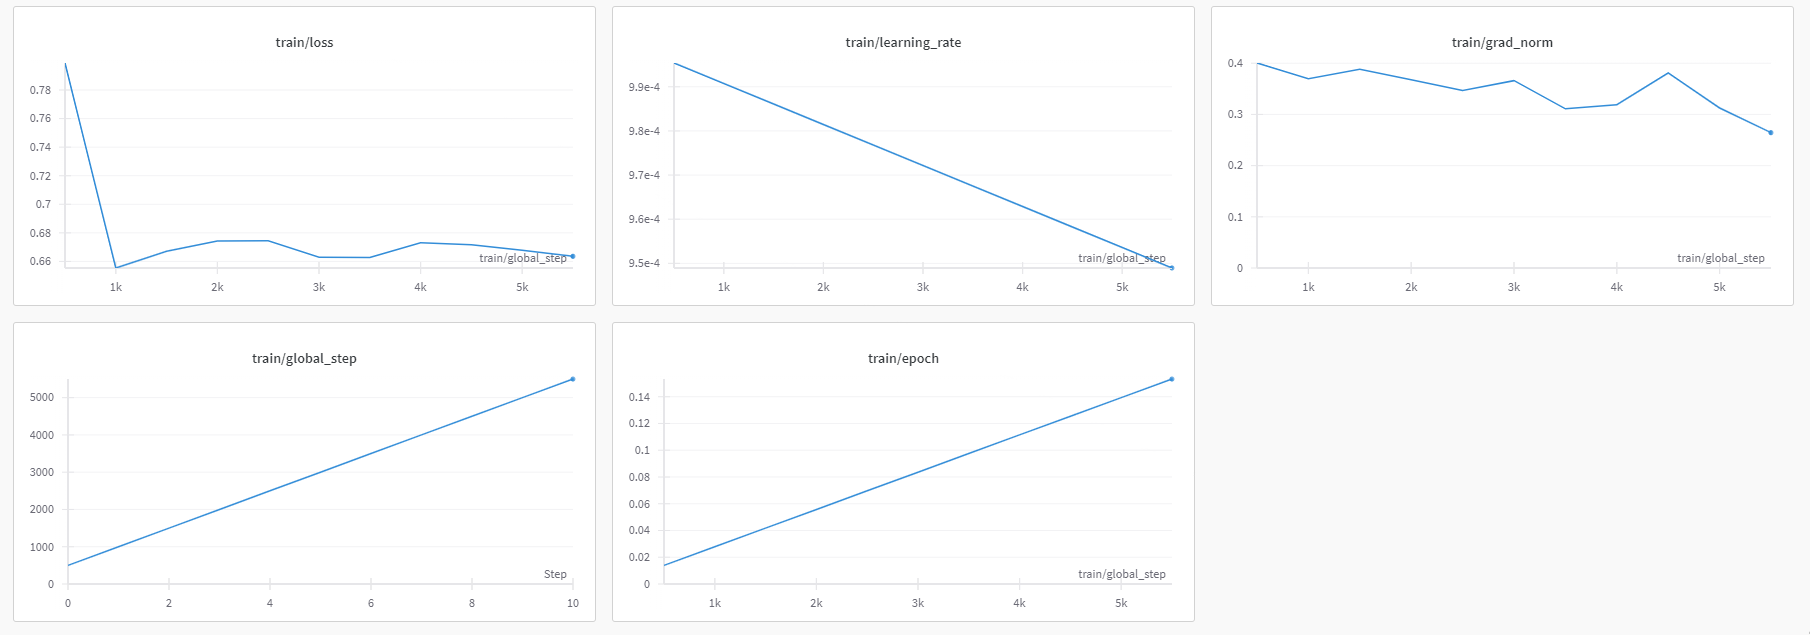

In [ ]:
pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("/content/why_do_i_need_a_dir_for_that/checkpoint-11500")

In [ ]:
gen = pretrained_model.generate(tokenizer.encode("Jimmy is an honest man. He just came back from Austria.", max_length=5, return_tensors="pt"))
tokenizer.decode(gen[0])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'<pad> Jimmy Jimmy is an honest honest honest Jimmy Jimmy. Jimmy is an honest honest honest honest honest'

### Compare your models (2 pts)

Use rouge metric. See the example above. <br>


Feed your own texts to both model and see the result


Add a conclusion

Мне честно очень лень тестировать на всём, так что просто наберем несколько индексов и посмотрим на результаты. Всё равно обе модели знатно недообучены, так что хороших результатов можно и не ждать в целом.

In [ ]:
gen = model.generate(tokenized_dataset["test"]["article"][2], tokenizer, max_out_length=256)
tokenizer.decode(gen, skip_special_tokens=True)

's Thousands of U.s are Yia says Iranian-born-born, Several nations to beheaded cites in Iran\'s s in U.: U.: "I\'s Thousands of Iran\'s Despite being held in U..com: ISIS in U. has since Yi is the Deputy PM: "I\'s Several U.com: Ivanda CDC ministers in New Year\'s\'s in U. is the U.: "Shammadi has been in U. issuing Iran\'s Several U.'

In [ ]:
tokenized_dataset["test"]["highlights"][2]

'Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister .\nHe once participated in a takeover of the Iranian Consulate in San Francisco .\nThe Iranian foreign minister tweets in English .'

In [ ]:
pre_gen = pretrained_model.generate(tokenizer.encode(tokenized_dataset["test"]["article"][2], return_tensors="pt", max_length=256))
tokenizer.decode(pre_gen[0])

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


"<pad> John Kerry's opposite number in securing a breakthrough in nuclear talks. He"

In [ ]:
test_ids = torch.randint(0, len(tokenized_dataset["test"]), (10,))
test_ids

tensor([ 9122,  5494,  4578, 10309,  8239,   339,  5224,   108,  8764,  3371])

In [ ]:
for id in test_ids:
    print(f"Original highlight of article {int(id)}:")
    print(tokenized_dataset["test"]["highlights"][id])
    print()

    gen = model.generate(tokenized_dataset["test"]["article"][2], tokenizer, max_out_length=256)
    print("My model prediction:")
    print(tokenizer.decode(gen, skip_special_tokens=True))
    print()
    gen += [tokenizer.pad_token_id]*(256-len(gen))
    print(compute_metrics([gen, tokenized_dataset["test"]["labels"][id]]))
    print()

    pre_gen = pretrained_model.generate(tokenizer.encode(tokenized_dataset["test"]["article"][id], return_tensors="pt", max_length=256))
    print("Pretrained model prediction:")
    print(tokenizer.decode(pre_gen[0], skip_special_tokens=True))
    zeros = torch.zeros(256-len(pre_gen[0]), dtype=int)
    print(compute_metrics([torch.cat((pre_gen[0], zeros)).tolist(), tokenized_dataset["test"]["labels"][id]]))
    print("\n\n")

Original highlight of article 9122:
Senator told Face the Nation same-sex marriage isn't a Constitutional right .
Added that it should be left up to the states to decide whether to allow it .
Comments came after sparking debate following an interview with Fusion .
Said he doesn't agree with gay marriage, but would attend a same-sex union if it was somebody he 'cared' for .

My model prediction:
s Despite the Yi says "S: "We's citesi is the world's in New Year-S.

{'rouge1': 0.0039, 'rouge2': 0.0, 'rougeL': 0.0039, 'rougeLsum': 0.0039, 'gen_len': 0.1211}

Pretrained model prediction:
Marco Rubio has claimed people are 'born with a sexual preference' while insisting
{'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0, 'rougeLsum': 0.0, 'gen_len': 0.0742}



Original highlight of article 5494:
Cheryl Howe, 32, was diagnosed with polycystic ovary syndrome at age 12 .
Morecambe mother-of-two fought for six years for treatment on the NHS .
Even Conchita Wurst sent her a note of support after abuse 

### My conclusion:

In general, I do not even know what to expect from poorly trained models here. Overall, I'd say that my model learned much more about predictions length, but it does not have any sense of how to construct a human-readeble sentence, which, in turn, the pre-trained model does just fine.  

In addition, both models can still give out not the summary for the submitted article, but garbage, often unrelated to the subject of the given article.

I am really sure that mostly these above mentioned problems could be easily solved with better and longer training. I just do not have that much time for now to train these models better.

From my side, it was quite painful to assemble my model manually. It's working now, but all this is a terrible mess with the sizes, my confusion between the tokenization of the dataset and the fact that these are not embeddings, bugs with the GPU that require switching to the CPU and restarting everything.

Training a model with HF Trainer has also not turned out to be an easy task. Not only does everything need to be adjusted according to the format, but it is also not entirely clear how the training takes place under the hood, if you do not get into the original implementation code. I didn't like it.

Both: mine and pretrained already models require significant amount of time without any bugs for training. Nice to have wandb, but training still might drop on kaggle and colab, causing painful and burning sensations in the lower back. And what next? **CORRECT, RE-TOKENIZE THE DATASET FOR 15 MINUTES**

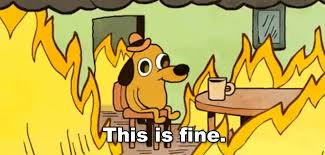